# IRC Channel Classifier

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import kneighbors_graph

In [58]:
import os 

project_dir = '/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/'
# project_dir = '/home/prenek/IRC-Behavioral-Analysis/'
log_dir = os.path.join(project_dir, 'zeek/logs/')
out_dir = os.path.join(project_dir, 'python/out/')

data = pd.read_csv(os.path.join(out_dir, 'irc_channel_features_all.csv'))
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data.head()

,pcap,channel,users_join_max,lang,msg_lev_dist_mean,msg_lev_dist_std,msg_periodicity,msg_frequency,spec_chars_mean,word_entropy,active_users,onechannel_users_ratio,network_info-num_services,network_info-num_users,malicious
0,34,##Summit,31.0,English,46.579578,27.772919,0.015128,0.001449,0.290818,8.103709,6,1.00,0.0,1.0,1
1,42,#Runz,2.0,Unidentified,NaN,NaN,NaN,NaN,0.000000,-0.000000,1,1.00,0.0,233.0,1
2,51,#007,12.0,English,28.437374,15.612790,0.025560,0.000189,0.486271,4.820940,3,0.00,0.0,1.0,1
3,51,#all,7.0,English,25.240929,19.280299,0.002190,0.002409,0.599392,4.278526,4,0.25,0.0,1.0,1
4,51,#kz,2.0,English,33.619459,33.149611,NaN,NaN,0.394054,5.244206,2,0.00,0.0,1.0,1


In [59]:
X = data.iloc[:, 2:-3]
y = data.iloc[:, -1]

X['lang'] = X['lang'].astype('category').cat.codes
X = X.apply(lambda x: x.fillna(x.mean()),axis=0)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=1)

## Experiment 1 - Unbalanced Dataset

Keep the same ratio between the samples when splitting between test/val/trn, no matter how many samples are malicious or benign
- to do this - comment code in experiment 2

In [61]:
# X, _X = X[:16], X[16:]
# y, _y = y[:16], y[16:]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=1)


X_test_big = X_test#np.concatenate([X_test, _X])
y_test_big = y_test#np.concatenate([y_test, _y])

# X_test_big = np.concatenate([X_test, _X])
# y_test_big = np.concatenate([y_test, _y])

## Experiment 2 - Balanced Dataset

Down-sample the majority class

In [62]:
n1 = y.shape[0]
n2 = y[y==0].shape[0]
n3 = y[y==1].shape[0]
# # showing examples of data
print('X: Info - \t Number of samples:\t\t{}\n\t\t Number of benign samples:\t{} \n\t\t Number of malicious samples\t{}\n'.format(n1,n2,n3))

n1 = y_train.shape[0]
n2 = y_train[y_train==0].shape[0]
n3 = y_train[y_train==1].shape[0]
# # showing examples of data
print('X_train: Info -  Number of samples:\t\t{}\n\t\t Number of benign samples:\t{} \n\t\t Number of malicious samples\t{}\n'.format(n1,n2,n3))

# n1 = y_val.shape[0]
# n2 = y_val[y_val==0].shape[0]
# n3 = y_val[y_val==1].shape[0]
# # # showing examples of data
# print('X_val: Info -  Number of samples:\t\t{}\n\t\t Number of benign samples:\t{} \n\t\t Number of malicious samples\t{}\n'.format(n1,n2,n3))

n1 = y_test.shape[0]
n2 = y_test[y_test==0].shape[0]
n3 = y_test[y_test==1].shape[0]
# # showing examples of data
print('X_test: Info -  Number of samples:\t\t{}\n\t\t Number of benign samples:\t{} \n\t\t Number of malicious samples\t{}'.format(n1,n2,n3))

X: Info - 	 Number of samples:		81
		 Number of benign samples:	73 
		 Number of malicious samples	8

X_train: Info -  Number of samples:		56
		 Number of benign samples:	50 
		 Number of malicious samples	6

X_test: Info -  Number of samples:		25
		 Number of benign samples:	23 
		 Number of malicious samples	2


In [63]:
sc = StandardScaler()
X = sc.fit_transform(X)
X_test = sc.transform(X_test)
X_train = sc.transform(X_train)
X_test_big = sc.transform(X_test_big)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversi

In [64]:
import random
def pick_color(n=1):
    colors = ["blue","black","brown","red","yellow","green","orange","beige","turquoise","pink"]
    random.shuffle(colors)
    return colors[:n]

## PCA

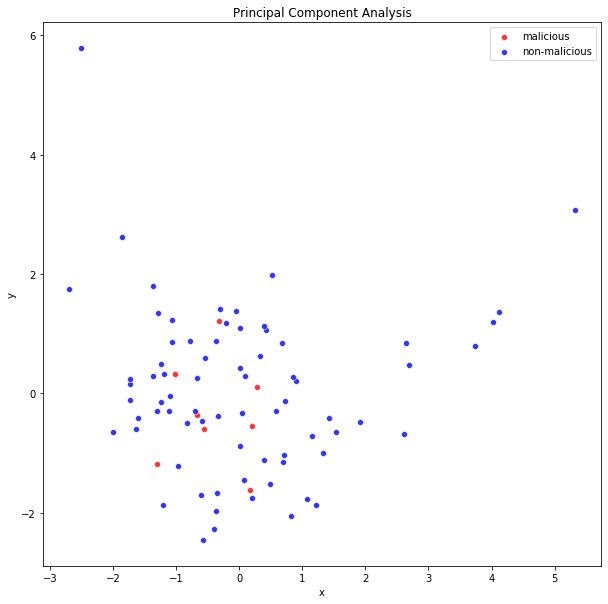

In [65]:
pca = PCA(n_components=2)
_pca = pca.fit(X)
X_pca_train = pca.transform(X_train)
X_pca = _pca.transform(X)
lw = 2
# increase fig size when the point annotation is enabled
plt.figure(figsize=(10,10))
plt.title('Principal Component Analysis')
group_offset = 0
for color, i, target_name in zip(['red','blue'], data.malicious.unique(), ['malicious','non-malicious']):
    _pca_data_x = X_pca[y == i, 0]
    _pca_data_y = X_pca[y == i, 1]
    _pca_df = pd.DataFrame({
        'x': _pca_data_x,
        'y': _pca_data_y,
        'group': list(range(group_offset, _pca_data_x.shape[0]+group_offset))
    })
    group_offset += _pca_data_x.shape[0]
    
    p1 = sns.scatterplot(x='x',y='y',data=_pca_df, color=color, alpha=.8,
                label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()

## T-SNE

In [66]:
# 2D
print('t-SNE 2D...')
X_tsne_2d = TSNE(n_components=2,verbose=0).fit_transform(X)
# 3D
print('t-SNE 3D...')
X_tsne_3d = TSNE(n_components=3,verbose=0).fit_transform(X)
print('Done.')

t-SNE 2D...
t-SNE 3D...
Done.


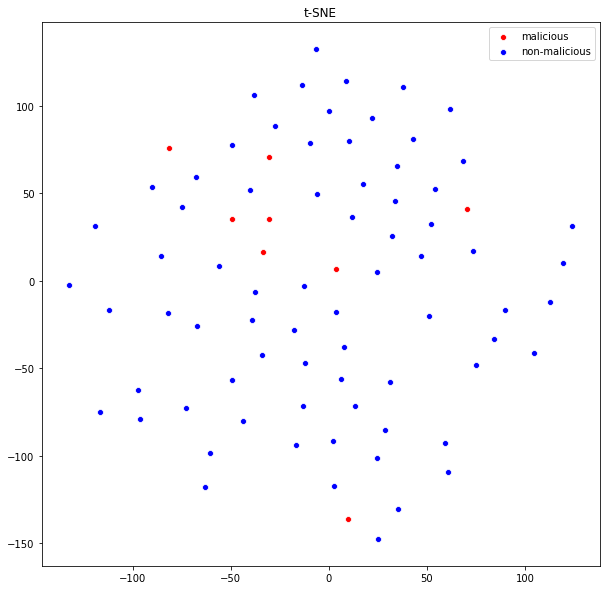

In [67]:
df_tsne_2d = pd.DataFrame({
    'x': X_tsne_2d[:,0],
    'y':X_tsne_2d[:,1],
    'label': y,
    'group': list(range(X_tsne_2d.shape[0]))
})



df_arr = []

for l in data.malicious.unique():
    df_arr.append(df_tsne_2d.where(df_tsne_2d.label==l))

plt.figure(figsize=(10,10))
plt.title('t-SNE')

for df, l, c in zip(df_arr,['malicious','non-malicious'], ["red","blue"]):
    sns.scatterplot(
        x='x',y='y',
        color=c,
        data=df,
        label=l,
        alpha=1)

plt.xlabel('')
plt.ylabel('')
plt.show()

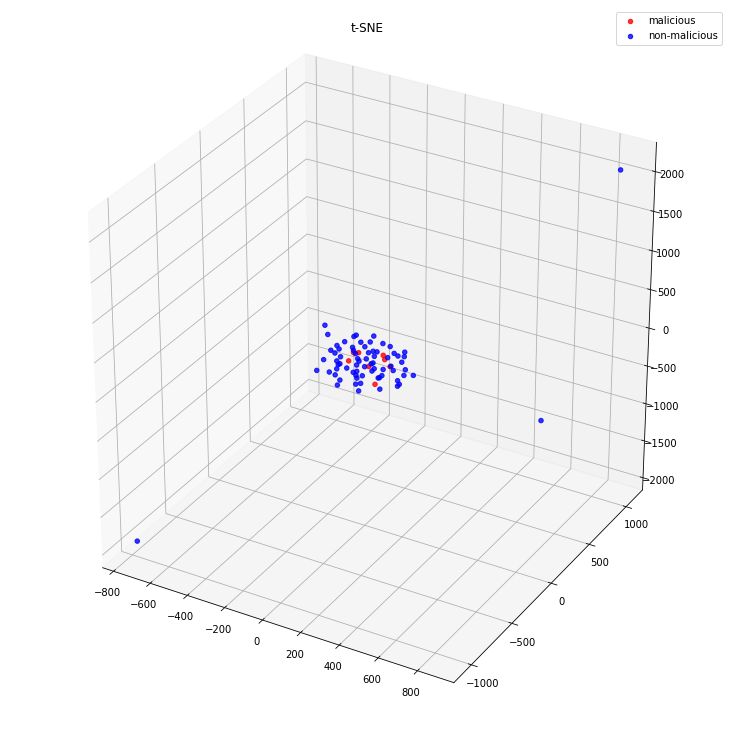

In [68]:
df_tsne_3d = pd.DataFrame({
    'x': X_tsne_3d[:,0],
    'y': X_tsne_3d[:,1],
    'z': X_tsne_3d[:,2],
    'label': y,
    'group': list(range(X_tsne_3d.shape[0]))
})

df_arr = []
for l in data.malicious.unique():
    df_arr.append(df_tsne_3d.where(df_tsne_3d.label==l))

fig = plt.figure(figsize=(10,10))
fig.suptitle('t-SNE')

ax = Axes3D(fig)

for df, l, c in zip(df_arr,['malicious','non-malicious'], ['red','blue']):
    ax.scatter(df.x, df.y, df.z, c=c, marker='o', alpha=0.8, label=l)

ax.legend()
plt.show()

In [69]:
y = y.astype('category').cat.codes
y_train = y_train.astype('category').cat.codes
y_test = y_test.astype('category').cat.codes

## UMAP

### UMAP - supervised

In [70]:
umap_emb = umap.UMAP(n_neighbors=5).fit(X_train, y=y_train).transform(X)

df_umap = pd.DataFrame({
    'x': umap_emb[:,0],
    'y': umap_emb[:,1],
    'label': y,
#     'group': list(range(umap_emb.shape[0]))
})

df_arr = []
for l in y.unique():
    df_arr.append(df_umap.where(df_umap.label==l))

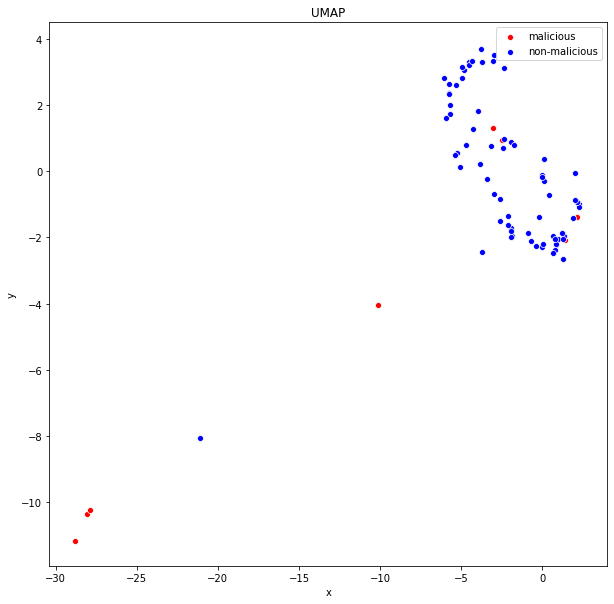

In [71]:
plt.figure(figsize=(10,10))
plt.title('UMAP')

for df, l, c in zip(df_arr, ['malicious','non-malicious'], ['red','blue']):
    sns.scatterplot(
        x='x',y='y',
        color=c,
        data=df,
        label=l,
        alpha=1)

### UMAP - unsupervised

In [72]:
umap_emb = umap.UMAP(n_neighbors=5).fit_transform(X)

df_umap = pd.DataFrame({
    'x': umap_emb[:,0],
    'y': umap_emb[:,1],
    'label': y,
    'group': list(range(umap_emb.shape[0]))
})

df_arr = []
for l in y.unique():
    df_arr.append(df_umap.where(df_umap.label==l))

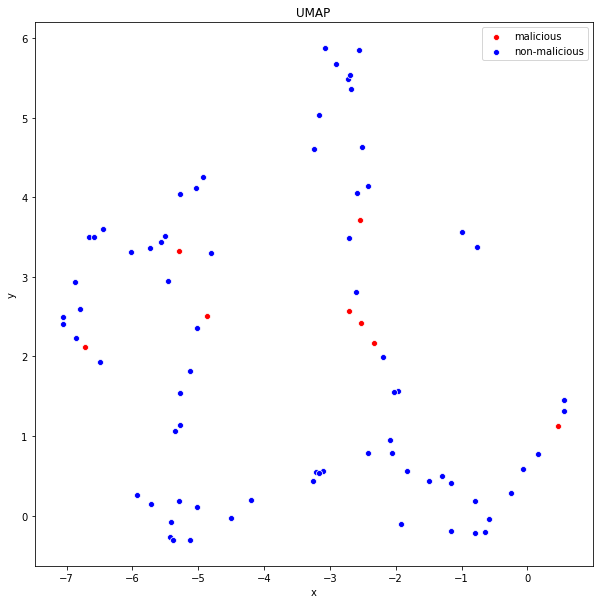

In [73]:
plt.figure(figsize=(10,10))
plt.title('UMAP')

for df, l, c in zip(df_arr, ['malicious','non-malicious'], ['red','blue']):
    sns.scatterplot(
        x='x',y='y',
        color=c,
        data=df,
        label=l,
        alpha=1)

## Unsupervised Learning

### K-Means

#### Determine optimal number of clusters for k-means


In [74]:
sse = []
for k in range(1,15):
    km = KMeans(n_clusters=k, init='k-means++', n_init=50,random_state=0 , tol=1.0e-9, verbose=0)
    km = km.fit(X)
    sse.append(km.inertia_)

print('optimal k is: ', np.argmin(sse))

optimal k is:  13


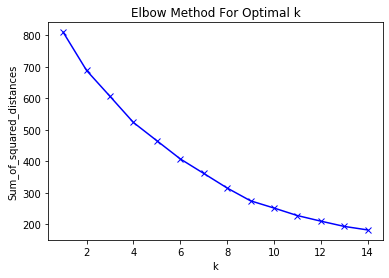

In [75]:
plt.plot(range(1,15), sse, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [76]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=50,random_state=0 , tol=1.0e-9, verbose=0)
kmeans.fit(X_train, y_train.values)
y_pred_kmeans = kmeans.predict(X_test_big)

print('K-Means accuracy:\t{}%'.format(round(accuracy_score(y_test_big, y_pred_kmeans)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y_test_big, y_pred_kmeans)*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y_test_big, y_pred_kmeans)*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y_test_big, y_pred_kmeans)*1e02,2)))

K-Means accuracy:	72.0%
	precision:	14.29%
	recall:		50.0%
	f1-score:	22.22%


#### K-Means - PCA embedded space

In [77]:
kmeans = KMeans(n_clusters=len(y_train.unique()), init='k-means++', n_init=50,random_state=0 , tol=1.0e-9, verbose=0)
kmeans.fit(X_pca)
y_pred_kmeans = kmeans.predict(X_pca)

print('K-Means-PCA: accuracy:\t{}%'.format(round(accuracy_score(y, y_pred_kmeans)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y, y_pred_kmeans)*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y, y_pred_kmeans)*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y, y_pred_kmeans)*1e02,2)))

K-Means-PCA: accuracy:	80.25%
	precision:	0.0%
	recall:		0.0%
	f1-score:	0.0%


#### K-Means - t-SNE 2D embedded space

In [78]:
tsne2d_train, tsne2d_test = train_test_split(df_tsne_2d,stratify=y, test_size=0.3, random_state=0)
kmeans = KMeans(n_clusters=len(y_train.unique()), init='k-means++', n_init=50,random_state=0 , tol=1.0e-9, verbose=0)
kmeans.fit(np.column_stack([tsne2d_train['x'], tsne2d_train['y']]))
y_tsne_2d_pred_kmeans = kmeans.predict(np.column_stack([tsne2d_test['x'],tsne2d_test['y']]))

print('K-Means-tsne 2D: accuracy:\t{}%'.format(round(accuracy_score(y_test, y_tsne_2d_pred_kmeans)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y_test,y_tsne_2d_pred_kmeans)*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y_test,y_tsne_2d_pred_kmeans)*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y_test,y_tsne_2d_pred_kmeans)*1e02,2)))

K-Means-tsne 2D: accuracy:	48.0%
	precision:	7.69%
	recall:		50.0%
	f1-score:	13.33%


#### K-Means - t-SNE 3D embedded space

In [79]:
tsne3d_train, tsne3d_test = train_test_split(df_tsne_3d, stratify=y, test_size=0.3, random_state=0)
kmeans = KMeans(n_clusters=len(y.unique()), init='k-means++', n_init=50,random_state=0 , tol=1.0e-9, verbose=0)
kmeans.fit(np.column_stack([tsne3d_train['x'], tsne3d_train['y'],tsne3d_train['z']]), tsne3d_train['label'])
y_tsne_3d_pred_kmeans = kmeans.predict(np.column_stack([tsne3d_test['x'],tsne3d_test['y'], tsne3d_test['z']]))

print('K-Means tsne 3D accuracy:\t{}%'.format(round(accuracy_score(y_test, y_tsne_3d_pred_kmeans)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y_test,y_tsne_3d_pred_kmeans)*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y_test,y_tsne_3d_pred_kmeans)*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y_test,y_tsne_3d_pred_kmeans)*1e02,2)))

K-Means tsne 3D accuracy:	92.0%
	precision:	0.0%
	recall:		0.0%
	f1-score:	0.0%


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### K-NN

In [80]:
from irc_utils import compute_score
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)
# Fit the classifier to the data
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test_big)

print('K-NN accuracy:\t{}%'.format(round(accuracy_score(y_test_big, y_pred_knn)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y_test_big,y_pred_knn)*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y_test_big,y_pred_knn)*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y_test_big,y_pred_knn)*1e02,2)))

K-NN accuracy:	92.0%
	precision:	50.0%
	recall:		50.0%
	f1-score:	50.0%


In [81]:
X_train.shape

(56, 10)

#### K-NN on PCA embedded space

In [82]:
knn_tsne2d = KNeighborsClassifier(n_neighbors = 3)
# Fit the classifier to the data
knn_tsne2d.fit(X_pca_train, y_train)

y_pred_knn_pca = knn_tsne2d.predict(X_pca)

print('K-NN PCA accuracy:\t{}%'.format(round(accuracy_score(y, y_pred_knn_pca)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y,y_pred_knn_pca)*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y,y_pred_knn_pca)*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y,y_pred_knn_pca)*1e02,2)))

K-NN PCA accuracy:	88.89%
	precision:	0.0%
	recall:		0.0%
	f1-score:	0.0%


#### K-NN on t-SNE 2D-embedded space

In [83]:
tsne2d_train, tsne2d_test = train_test_split(df_tsne_2d, stratify=y, test_size=0.3, random_state=0)
knn_tsne2d = KNeighborsClassifier(n_neighbors = 3)
# Fit the classifier to the data
knn_tsne2d.fit(np.column_stack([df_tsne_2d['x'],df_tsne_2d['y']]),y)

y_pred_knn_tsne2d = knn_tsne2d.predict(np.column_stack([df_tsne_2d['x'],df_tsne_2d['y']]))

print('K-NN t-SNE 2D accuracy:\t{}%'.format(round(accuracy_score(y, y_pred_knn_tsne2d)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y,y_pred_knn_tsne2d)*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y,y_pred_knn_tsne2d)*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y,y_pred_knn_tsne2d)*1e02,2)))

K-NN t-SNE 2D accuracy:	92.59%
	precision:	75.0%
	recall:		37.5%
	f1-score:	50.0%


#### K-NN on t-SNE 3D-embedded space

In [84]:
tsne3d_train, tsne3d_test = train_test_split(df_tsne_3d, stratify=y, test_size=0.3, random_state=0)
knn_tsne3d = KNeighborsClassifier(n_neighbors = 3)
# Fit the classifier to the data
knn_tsne3d.fit(np.column_stack([tsne3d_train['x'],tsne3d_train['y'], tsne3d_train['z']]), y_train)

y_pred_knn_tsne3d = knn_tsne3d.predict(np.column_stack([tsne3d_test['x'],tsne3d_test['y'],tsne3d_test['z']]))

print('K-NN t-SNE 3D accuracy:\t{}%'.format(round(accuracy_score(y_test, y_pred_knn_tsne3d)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y_test,y_pred_knn_tsne3d)*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y_test,y_pred_knn_tsne3d)*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y_test,y_pred_knn_tsne3d)*1e02,2)))

K-NN t-SNE 3D accuracy:	92.0%
	precision:	0.0%
	recall:		0.0%
	f1-score:	0.0%


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### Hierarchical Clustering

In [85]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=len(y.unique()), affinity='euclidean', linkage='ward')

y_pred_knn_cluster = cluster.fit_predict(X)

print('AgglomerativeClustering accuracy:\t{}%'.format(round(accuracy_score(y, y_pred_knn_cluster)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y,y_pred_knn_cluster)*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y,y_pred_knn_cluster)*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y,y_pred_knn_cluster)*1e02,2)))

AgglomerativeClustering accuracy:	38.27%
	precision:	12.5%
	recall:		87.5%
	f1-score:	21.88%


# Supervised Learning

## Linear Regression

In [86]:
from sklearn.linear_model import SGDClassifier
# C, kernel, gamma = clf.best_params_['C'], clf.best_params_['kernel'], clf.best_params_['gamma']
linreg = SGDClassifier()

linreg.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [87]:
y_pred = linreg.predict(X_test_big)

print('Linear Regression accuracy:\t{}%'.format(round(accuracy_score(y_test_big, y_pred)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y_test_big,y_pred)*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y_test_big,y_pred)*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y_test_big,y_pred)*1e02,2)))

Linear Regression accuracy:	80.0%
	precision:	20.0%
	recall:		50.0%
	f1-score:	28.57%


## Logistic Regression

In [88]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20)
    }
]

# Create grid search object
pipe = Pipeline([('classifier' , LogisticRegression())])
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train, y_train)
logreg_model = best_clf.best_params_['classifier']

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.3s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [89]:
best_clf.best_params_

{'classifier': LogisticRegression(C=0.0001, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
           solver='warn', tol=0.0001, verbose=0, warm_start=False),
 'classifier__C': 0.0001,
 'classifier__penalty': 'l1'}

In [90]:
y_pred = logreg_model.predict(X_test_big)

print('Logistic Regression accuracy:\t{}%'.format(round(accuracy_score(y_test_big, y_pred)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y_test_big,y_pred)*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y_test_big,y_pred)*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y_test_big,y_pred)*1e02,2)))

Logistic Regression accuracy:	92.0%
	precision:	0.0%
	recall:		0.0%
	f1-score:	0.0%


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [91]:
train_ratio = np.arange(0.6,0.95,0.005)
n_samples = len(X)
train_size = []#list(map(lambda x: round(x*n_samples), train_ratio))

score_trn_list = []
score_tst_list = []
for trn_ratio in train_ratio:
    print(y)
    X_tmp, _, y_tmp, _ = train_test_split(X, y, train_size=trn_ratio, stratify=y, random_state=0)
    train_size.append(len(X_tmp))
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_tmp, y_tmp, stratify=y_tmp, train_size=0.8, random_state=0)
    logreg = LogisticRegression()
    logreg.fit(X_train2, y_train2)
    
    y_pred_trn = logreg.predict(X_train2)
    y_pred_tst = logreg.predict(X_test2)
    
    score_trn = f1_score(y_train2, y_pred_trn)
    score_tst = f1_score(y_test2, y_pred_tst)
    score_trn_list.append(score_trn)
    score_tst_list.append(score_tst)

print('shape: {},{}'.format(len(score_trn_list), score_trn_list[0]))
score_trn_list = np.stack(score_trn_list, axis=0)
score_tst_list = np.stack(score_tst_list, axis=0)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are 

0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtyp

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWa

0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are 

0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtyp

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWa

0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtyp

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted sample

0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtype: int8
0     1
1     1
2     1
3     1
4     1
     ..
76    0
77    0
78    0
79    0
80    0
Length: 81, dtyp

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted sample

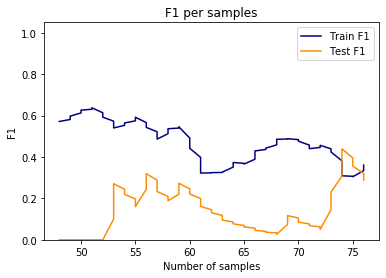

In [92]:
from irc_utils import exponential_moving_average
trn_score_f1 = exponential_moving_average(score_trn_list, 0.1)
tst_score_f1 = exponential_moving_average(score_tst_list, 0.1)

plt.title("F1 per samples")
plt.xlabel('Number of samples')
plt.ylabel('F1')
plt.plot(train_size, trn_score_f1, label='Train F1',color='navy')
plt.plot(train_size, tst_score_f1, label='Test F1',color="darkorange")
plt.legend(loc="best")
plt.ylim(0,1.05)
plt.show()

## SVM

In [93]:
from sklearn.svm import SVC

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
                   ]


#     print("# Tuning hyper-parameters for %s" % score)
#     print()

clf = GridSearchCV(SVC(C=1), tuned_parameters,cv=3)
clf.fit(X, y)

clf.best_params_

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}

In [94]:
C, kernel, gamma = clf.best_params_['C'], clf.best_params_['kernel'], clf.best_params_['gamma']
my_svm = SVC(C=C, kernel=kernel, gamma=gamma, probability=True, verbose=True)
my_svm.fit(X_train, y_train)

[LibSVM]

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [95]:
y_pred = my_svm.predict(X_test_big)

print('SVM accuracy:\t{}%'.format(round(accuracy_score(y_test_big, y_pred)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y_test_big,y_pred)*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y_test_big,y_pred)*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y_test_big,y_pred)*1e02,2)))

SVM accuracy:	92.0%
	precision:	0.0%
	recall:		0.0%
	f1-score:	0.0%


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [96]:
train_ratio = np.arange(0.5,1,0.005)
n_samples = len(X)
train_size = []#list(map(lambda x: round(x*n_samples), train_ratio))

score_trn_list = []
score_tst_list = []
for trn_ratio in train_ratio:
    X_tmp, _, y_tmp, _ = train_test_split(X, y, train_size=trn_ratio, random_state=0)
    train_size.append(len(X_tmp))
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_tmp, y_tmp, train_size=0.8, random_state=0)
    svc = SVC()
    svc.fit(X_train2, y_train2)
    
    y_pred_trn = svc.predict(X_train2)
    y_pred_tst = svc.predict(X_test2)
    
    score_trn = f1_score(y_train2, y_pred_trn)
    score_tst = f1_score(y_test2, y_pred_tst)
    score_trn_list.append(score_trn)
    score_tst_list.append(score_tst)

print('shape: {},{}'.format(len(score_trn_list), score_trn_list[0]))
score_trn_list = np.stack(score_trn_list, axis=0)
score_tst_list = np.stack(score_tst_list, axis=0)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWa

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid t

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid t

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid t

shape: 100,0.0


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid t

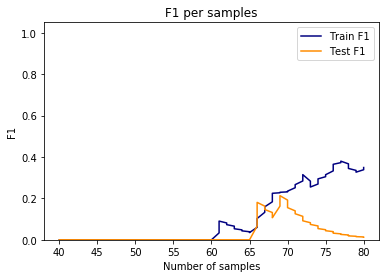

In [97]:
trn_score_f1 = exponential_moving_average(score_trn_list, 0.1)
tst_score_f1 = exponential_moving_average(score_tst_list, 0.1)

plt.title("F1 per samples")
plt.xlabel('Number of samples')
plt.ylabel('F1')
plt.plot(train_size, trn_score_f1, label='Train F1',color='navy')
plt.plot(train_size, tst_score_f1, label='Test F1',color="darkorange")
plt.legend(loc="best")
plt.ylim(0,1.05)
plt.show()

## Random Forrest

In [98]:
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
param_range = range(1,10)
train_scores, test_scores = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = param_range, cv = 3)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

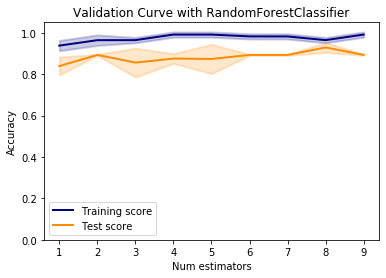

In [99]:
plt.title("Validation Curve with RandomForestClassifier")
plt.xlabel('Num estimators')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
              color="navy", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.plot(param_range, test_scores_mean, label="Test score",
              color="darkorange", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.legend(loc="best")
plt.show()

### Exhaustive Grid Search

In [100]:
from sklearn.model_selection import GridSearchCV

n_estimators = [1,5,10,15, 20]
max_depth = [1,2,3,4,5,10]
min_samples_split = [2,3,4,5,10,15,20]
min_samples_leaf = [1,2,3,4,5,10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(RandomForestClassifier(), hyperF, cv = 3, verbose = 1, n_jobs=-1)
bestF = gridF.fit(X_train, y_train)
print('''Best parameters: \n
- max_depth: {} \n
- min_samples_leaf: {} \n
- min_samples_split: {} \n
- n_estimators: {}'''.format(bestF.best_params_['max_depth'],
                             bestF.best_params_['min_samples_leaf'],
                             bestF.best_params_['min_samples_split'],
                             bestF.best_params_['n_estimators']))

Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 3552 tasks      | elapsed:   51.4s


Best parameters: 

- max_depth: 3 

- min_samples_leaf: 3 

- min_samples_split: 2 

- n_estimators: 5


[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed:   54.7s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [101]:
max_depth = bestF.best_params_['max_depth']
min_samples_leaf = bestF.best_params_['min_samples_leaf']
min_samples_split = bestF.best_params_['min_samples_split']
n_estimators = bestF.best_params_['n_estimators']

model = RandomForestClassifier(max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf,
                               min_samples_split=min_samples_split,
                               n_estimators=n_estimators)
model.fit(X_train, y_train)
y_pred = model.predict(X_test_big)

In [102]:
print('Random Forrest accuracy:\t{}%'.format(round(accuracy_score(y_test_big, y_pred)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y_test_big,y_pred)*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y_test_big,y_pred)*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y_test_big,y_pred)*1e02,2)))

Random Forrest accuracy:	92.0%
	precision:	0.0%
	recall:		0.0%
	f1-score:	0.0%


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [103]:
print(model.feature_importances_)

[0.07692308 0.         0.06857143 0.14874142 0.10181818 0.05125858
 0.42961039 0.12307692 0.         0.        ]


In [104]:
train_ratio = np.arange(0.5,1,0.01)
n_samples = len(X)
train_size = []#list(map(lambda x: round(x*n_samples), train_ratio))

score_trn_list = []
score_tst_list = []
for trn_ratio in train_ratio:
    X_tmp, _, y_tmp, _ = train_test_split(X, y, train_size=trn_ratio, random_state=0)
    train_size.append(len(X_tmp))
    X_train, X_test, y_train, y_test = train_test_split(X_tmp, y_tmp, train_size=0.7, random_state=0)
    model = RandomForestClassifier(max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf,
                               min_samples_split=min_samples_split,
                               n_estimators=n_estimators)
    model.fit(X_train, y_train)
    y_pred_trn = model.predict(X_train)
    y_pred_tst = model.predict(X_test)

    score_trn = f1_score(y_train, y_pred_trn)
    score_tst = f1_score(y_test, y_pred_tst)
    score_trn_list.append(score_trn)
    score_tst_list.append(score_tst)
    
print('shape: {},{}'.format(len(score_trn_list), score_trn_list[0]))
score_trn_list = np.stack(score_trn_list, axis=0 )
score_tst_list = np.stack(score_tst_list, axis=0 )

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples

shape: 50,0.0


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


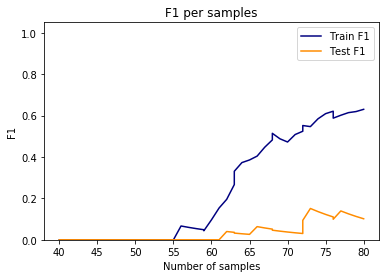

In [105]:
trn_score_f1 = exponential_moving_average(score_trn_list, 0.1)
tst_score_f1 = exponential_moving_average(score_tst_list, 0.1)

plt.title("F1 per samples")
plt.xlabel('Number of samples')
plt.ylabel('F1')
plt.plot(train_size, trn_score_f1, label='Train F1',color='navy')
plt.plot(train_size, tst_score_f1, label='Test F1',color="darkorange")
plt.legend(loc="best")
plt.ylim(0, 1.05)
plt.show()

## Feature Importance

In [106]:
print(model.feature_importances_)

[0.50707965 0.         0.         0.         0.         0.
 0.37426133 0.09181537 0.         0.02684366]


# XGBoost 

#### Validation curve

In [107]:
import xgboost as xgb
from sklearn.model_selection import validation_curve
param_range = range(1,10)
train_scores, test_scores = validation_curve(
                                xgb.XGBClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = param_range, cv = 3)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

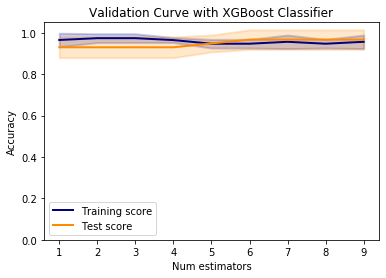

In [108]:
plt.title("Validation Curve with XGBoost Classifier")
plt.xlabel('Num estimators')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
              color="navy", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.plot(param_range, test_scores_mean, label="Test score",
              color="darkorange", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.legend(loc="best")
plt.show()

#### Exhaustive Grid Search

In [109]:
from sklearn.model_selection import GridSearchCV

parameters =    {
            'max_depth': [2, 3, 4, 5],
            'n_estimators': [5, 10, 25],
            'gamma': [0, 0.1, 0.2],
            'min_child_weight': [0, 0.5, 1],
            'colsample_bytree': [0.6, 0.8, 1],
            'reg_alpha': [1e-2, 1e-1, 1e1,10],
            'reg_lambda': [1e-2, 1e-1, 1e1,10],
            }

clf = GridSearchCV(xgb.XGBClassifier(), parameters, scoring = 'accuracy', cv = 3, verbose = 1, n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 5184 candidates, totalling 15552 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 5104 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 13104 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 15552 out of 15552 | elapsed:   16.8s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5], 'n_estimators': [5, 10, 25], 'gamma': [0, 0.1, 0.2], 'min_child_weight': [0, 0.5, 1], 'colsample_bytree': [0.6, 0.8, 1], 'reg_alpha': [0.01, 0.1, 10.0, 10], 'reg_lambda': [0.01, 0.1, 10.0, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [110]:
p = clf.best_params_
clf.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 5,
 'reg_alpha': 0.01,
 'reg_lambda': 0.01}

In [111]:
xgb_model = xgb.XGBClassifier(colsample_bytree=0.6, gamma=0, max_depth=2,
 min_child_weight=0, n_estimators=10, reg_alpha=0.01,reg_lambda=0.01)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=0, missing=None, n_estimators=10, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01, reg_lambda=0.01, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [112]:
y_pred = xgb_model.predict(X_test)

print('XGBoost accuracy:\t{}%'.format(round(accuracy_score(y_test, y_pred)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y_test,y_pred)*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y_test,y_pred)*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y_test,y_pred)*1e02,2)))

XGBoost accuracy:	83.33%
	precision:	0.0%
	recall:		0.0%
	f1-score:	0.0%


In [113]:
train_ratio = np.arange(0.5,0.9,0.005)
n_samples = len(X)
train_size = []#list(map(lambda x: round(x*n_samples), train_ratio))

score_trn_list = []
score_tst_list = []
for trn_ratio in train_ratio:
    X_tmp, _, y_tmp, _ = train_test_split(X, y, stratify=y, train_size=trn_ratio, random_state=0)
    train_size.append(len(X_tmp))
    X_train, X_test, y_train, y_test = train_test_split(X_tmp, y_tmp, stratify=y_tmp, train_size=0.7, random_state=0)
    model = xgb.XGBClassifier(colsample_bytree=0.6, gamma=0, max_depth=2, 
                              min_child_weight=0, n_estimators=10, reg_alpha=0.01,reg_lambda=0.01)
    model.fit(X_train, y_train)
    y_pred_trn = model.predict(X_train)
    y_pred_tst = model.predict(X_test)

    score_trn = f1_score(y_train, y_pred_trn)
    score_tst = f1_score(y_test, y_pred_tst)
    score_trn_list.append(score_trn)
    score_tst_list.append(score_tst)
    
print('shape: {},{}'.format(len(score_trn_list), score_trn_list[0]))
score_trn_list = np.stack(score_trn_list, axis=0 )
score_tst_list = np.stack(score_tst_list, axis=0 )

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarn

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarn

shape: 80,1.0


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_

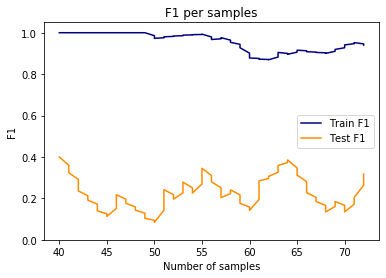

In [114]:
trn_score_f1 = exponential_moving_average(score_trn_list, 0.1)
tst_score_f1 = exponential_moving_average(score_tst_list, 0.1)

plt.title("F1 per samples")
plt.xlabel('Number of samples')
plt.ylabel('F1')
plt.plot(train_size, trn_score_f1, label='Train F1',color='navy')
plt.plot(train_size, tst_score_f1, label='Test F1',color="darkorange")
plt.legend(loc="best")
plt.ylim(0, 1.05)
plt.show()

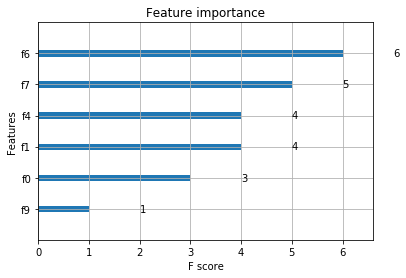

In [115]:
from xgboost import plot_importance

plot_importance(xgb_model)